# Introduction to fractal dimension 
In this notebook we will discuss the concept of parametrization of the surface at different scales in a deeper manner. We introduce the fractal dimension.

In [1]:
!pip install Shapely
!pip install geopandas

  Using cached https://files.pythonhosted.org/packages/74/42/f4b147fc7920998a42046d0c2e65e61000bc5d104f1f8aec719612cb2fc8/geopandas-0.5.0-py2.py3-none-any.whl
    Complete output from command python setup.py egg_info:
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    
    ----------------------------------------


Command "python setup.py egg_info" failed with error code 1 in C:\Users\Giacomo\AppData\Local\Temp\pip-install-xz8s7tp0\fiona\


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point,MultiPoint
from matplotlib2tikz import save as tikz_save
import geopandas

%matplotlib inline
plt.rcParams["figure.figsize"] = (18,3)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 106: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 99: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 100: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 105: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 101: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 102: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 98: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 97: invalid continuation byte


In [ ]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -1, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

Now we define a `LineString` data structure for rappresenting the profile.

In [26]:
list_of_point = zip(xp,yp)
profile = LineString(list_of_point)

In [27]:
sampling_radius = 5
def find_inter(p,sampling_radius,profile=profile):
    # Create a circle c with a radius = sampling radius.
    c = p.buffer(sampling_radius).boundary
    # Find intersection of the circle with the profile.
    i = c.intersection(profile)
    #print i
    return i


In [28]:
p1 = find_inter(Point(list_of_point[0]),sampling_radius=sampling_radius)
print p1


POINT (3.514412095785459 2.477551087447786)


In [29]:
%qt_console

UsageError: Line magic function `%qt_console` not found.


In [30]:
go = True
count = 0
point = Point(list_of_point[0])
intersections  = []
points_found = []
points_found.append(point)
for i in range(40):
    pointx = point.coords[0][0]
    point = find_inter(point,sampling_radius)
    count +=1
    intersections.append(point)
    if type(point) is MultiPoint:
        listx = np.array([i.coords[0][0] for i in point])
        # find the smallest value the closest to the origin
        value = listx[listx > pointx].min()
        itemindex = np.where(listx==value)
        point = point[itemindex[0][0]]
        points_found.append(point)
    else:
        points_found.append(point)

In [31]:
multi = intersections[3]
multi[0].coords[0]

(6.851585841287535, 0.18716686054318937)

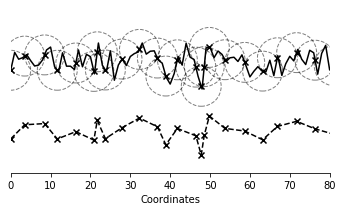

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax.plot(xp,yp,'k-')
for inter in intersections:
    if type(inter) is MultiPoint:
        for j in inter:
            x,y = j.coords[0]
            #ax.scatter(x,y,color='k',marker='x',alpha=0.5)
    else:
        x,y = inter.coords[0]
        #ax.scatter(x,y,color='b',marker='x')
for pt in points_found:
    x,y = pt.coords[0]
    circle1 = plt.Circle((x, y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax.add_artist(circle1)

xn,yn = np.array([pt.coords[0] for pt in points_found]).T
ax.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - sampling_radius*1.2
ax.plot(xn,shifteyn,linestyle='--',color='k')
ax.scatter(xn,shifteyn,color='k',marker='x')
ax.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+sampling_radius*1.2)
ax.set_xlim(0,80)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("Coordinates")
#fig.savefig("fig3.pgf")
#tikz_save("test3.tex")
# unit vector ratio*=1 1 1,
plt.show()



In [54]:
gbr = geopandas.read_file('GBR_adm0.shp')
area_max = 0 
result = None
for idx,i  in enumerate(gbr.geometry[0]):
    if i.area > area_max:
        area_max = i.area
        result = idx
print result
#print gbr.geometry[0][815]
gbr.loc[(0,2),'geometry']

815


0    (POLYGON ((-6.387915134429932 49.8687515258791...
2                                                  NaN
Name: geometry, dtype: object

# Rolling circle envelope 
The method used by Richardson, maybe substit

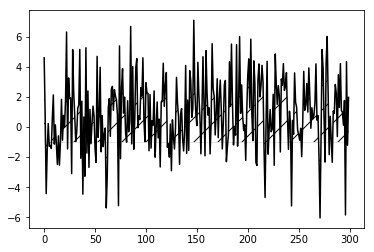

In [11]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -1, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

In [12]:
list_of_point = zip(xp,yp)
profile = LineString(list_of_point)

In [13]:
circle_radius = 2
max_value = max(yp)
# The circle will never encounter value above the max value of the profile
starting_ycoord = max_value + circle_radius
min_ycord = min(yp) + circle_radius
# TODO: we could optimize the range over windows of the size of the diameters.
points = []
traiectory = []
for step in range(40):
    xcoor = list_of_point[step][0]
    max_value = list_of_point[step][1] + circle_radius*0.9
    for y in np.linspace(starting_ycoord,max_value):
        p = Point(xcoor,y)
        # Create a circle c with a radius = sampling radius.
        c = p.buffer(circle_radius).boundary
        # Find intersection of the circle with the profile.
        traiectory.append((xcoor,y))
        if c.intersects(profile):
            points.append((xcoor,y))
            break

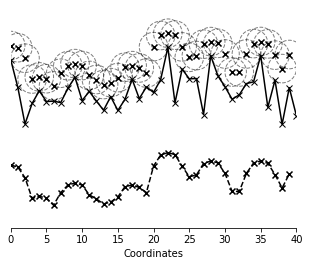

In [14]:

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax2.plot(xp,yp,'k',marker = 'x')

for pt in points:
    circle1 = plt.Circle(pt, circle_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax2.add_artist(circle1)
#traiectory
#xt,yt = np.array(traiectory).T
#ax2.scatter(xt,yt,color='g',marker = 'x',alpha=0.4)
    
xn,yn = np.array(points).T
ax2.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax2.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - circle_radius*1.2
ax2.plot(xn,shifteyn,linestyle='--',color='k')
ax2.scatter(xn,shifteyn,color='k',marker='x')
ax2.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+circle_radius*2.2)
ax2.set_xlim(0,40)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_xlabel("Coordinates")
#fig.savefig("fig3.pgf")
#tikz_save("test3.tex")
# unit vector ratio*=1 1 1,
plt.show()


In [7]:
%qtconsole